In [1]:
from janus_wraper import *
import torch
from transformers import AutoModelForCausalLM
from Janus.janus.models import MultiModalityCausalLM, VLChatProcessor
from Janus.janus.utils.io import load_pil_images

# specify the path to the model
# model_path = "/projectnb/cs598/projects/cool_proj/model"
# device = 'cuda'
model_path = '/Users/nover/models/deepseek-ai/Janus-Pro-7B'
device = 'mps'

chat_processor: VLChatProcessor = VLChatProcessor.from_pretrained(model_path)

gpt: MultiModalityCausalLM = AutoModelForCausalLM.from_pretrained(
    model_path, trust_remote_code=True
)
gpt = gpt.to(torch.bfloat16).to(device).eval()





Python version is above 3.10, patching the collections module.
Python version is above 3.10, patching the collections module.


/Users/nover/repos/class/.venv/lib/python3.12/site-packages/transformers/models/auto/image_processing_auto.py:593: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thorou

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
text_prompt = 'Where is this image from?'

# # Load the image from a file
image = Image.open("img.jpg")
# tokenizer = vl_chat_processor.tokenizer

# Call the unified function for multimodal understanding (text output)
result = janus_pro_generate(
    chat_processor,
    gpt,
    device=device,
    input_text=text_prompt,
    input_image=image,
    output_mode="text",
)
print(result)


This image appears to be from a parade or military event, possibly in a country with a significant military presence. The tanks and the presence of a person walking in front of them suggest a formal display or procession.


In [2]:
text_prompt = 'make this image a meme'

# # Load the image from a file
image = Image.open("img.jpg")
# tokenizer = vl_chat_processor.tokenizer

# Call the unified function for multimodal understanding (text output)
result = janus_pro_generate(
    chat_processor,
    gpt,
    device=device,
    input_text=text_prompt,
    input_image=image,
    output_mode="image",
    guidance=5,
    t2i_temperature=1.0,
    num_images=2,
    # width=192,
    # height=192,
)


RuntimeError: shape '[2, 12, 12, 8]' is invalid for input of size 9216

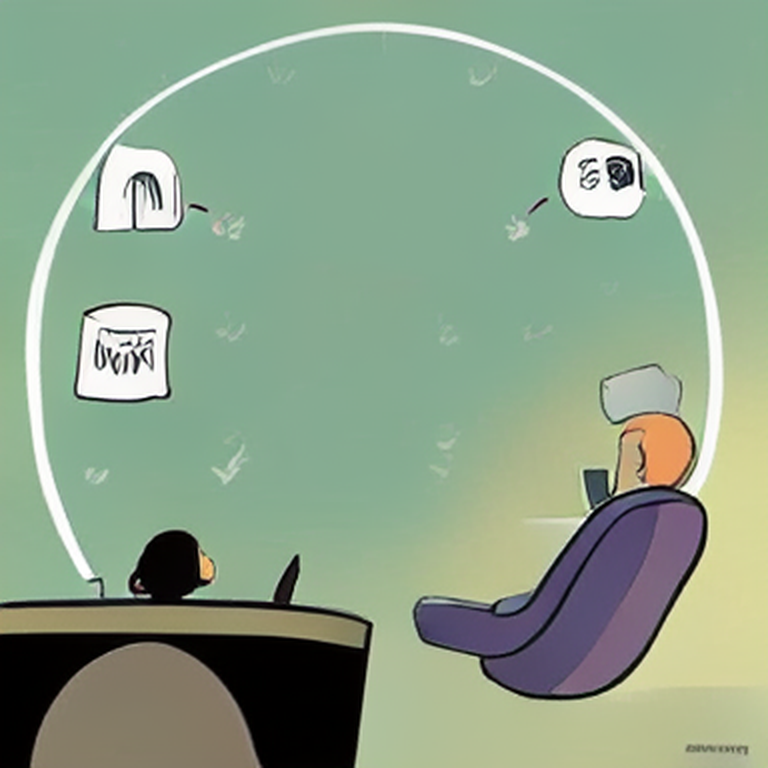

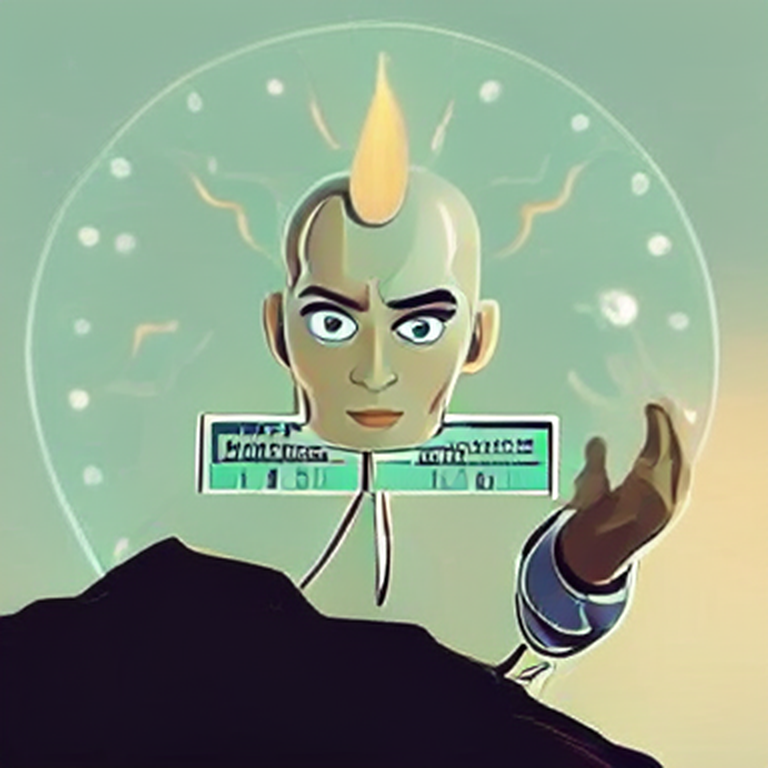

Generated Text Response:


In [5]:
# Save generated images to disk.
for idx, img in enumerate(result):
    display(img)


# Print the generated text response
print("Generated Text Response:")